# Projet Spark - Covid VS Societé 2020

## Problematique
### Quelle est l'impacte du covid sur les société en France sur l'année 2020 ?


In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.types import DoubleType, IntegerType

**Création de la session spark**

In [2]:
spark = SparkSession.builder.appName("covid_societe").getOrCreate()

**Lecture du fichier des données covid-19**

In [3]:
path_file_data = "../data/donnees_covid_societes/"

df_covid_par_dep = spark.read.csv(
    path_file_data + "covid/covid_quotidien_par_dep_du_patient/donnees-hospitalieres-nouveaux-covid19.csv",
    header=True,
    sep=";"
)
df_metadonne_covid_par_dep_et_sexe_patient = spark.read.csv(
    path_file_data + "covid/covid_quotidien_par_dep_du_patient/metadonnees-hospit-incid.csv",
    header=True,
    sep=";"
)

# Affichage des metadonnés
df_metadonne_covid_par_dep_et_sexe_patient.select(
    "Colonne",
    "Type ",
    "Description_FR"
).filter(
    df_metadonne_covid_par_dep_et_sexe_patient.Colonne.isNotNull()
).show(20, False)

# Affichage des données
df_covid_par_dep = df_covid_par_dep.filter(df_covid_par_dep.jour >= '01/01/2021')
df_covid_par_dep.show()

# La plus grande date
print("La plus grande date :")
df_covid_par_dep.orderBy('jour', ascending=False).show(1)

+----------+-------------+--------------------------------------------------------+
|Colonne   |Type         |Description_FR                                          |
+----------+-------------+--------------------------------------------------------+
|dep       |integer      |Département                                             |
|jour      |string($date)|Date de notification                                    |
|incid_hosp|string       |Nombre quotidien de personnes nouvellement hospitalisées|
|incid_rea |integer      |Nombre quotidien de nouvelles admissions en réanimation |
|incid_dc  |integer      |Nombre quotidien de personnes nouvellement décédées     |
|incid_rad |integer      |Nombre quotidien de nouveaux retours à domicile         |
+----------+-------------+--------------------------------------------------------+

+---+----------+----------+---------+--------+---------+
|dep|      jour|incid_hosp|incid_rea|incid_dc|incid_rad|
+---+----------+----------+---------+--------

### Quelle departement a eu le plus d'hospitalisation, de réanimation et de déces ? (ecrire dans un csv dans /resultat)

In [4]:
df_covid_sum_par_dep = df_covid_par_dep.groupBy(
    "dep"
).agg( 
    # On fait la somme de chaque colonne puis on cast le resultat en INTEGER et on le renomme
    f.sum("incid_hosp").cast(IntegerType()).alias('incid_hosp'), 
    f.sum("incid_rea").cast(IntegerType()).alias('incid_rea'),
    f.sum("incid_rad").cast(IntegerType()).alias('incid_rad'),
    f.sum("incid_dc").cast(IntegerType()).alias('incid_dc')
).orderBy("dep",ascending=True)

# df_covid_sum_par_dep.show()

# On recupere les valeurs max
max_hospi = df_covid_sum_par_dep.groupBy().max("incid_hosp").collect()[0]["max(incid_hosp)"]
max_rea = df_covid_sum_par_dep.groupBy().max("incid_rea").collect()[0]["max(incid_rea)"]
max_dc = df_covid_sum_par_dep.groupBy().max("incid_dc").collect()[0]["max(incid_dc)"]

#### Département avec le plus d'hospitalisation

In [5]:
# Le département avec le plus d'hospitalisation
df_covid_max_hospi = df_covid_sum_par_dep.filter(
    f.col("incid_hosp") == max_hospi    
).select(
    "dep",
    "incid_hosp"
)
df_covid_max_hospi.show()

+---+----------+
|dep|incid_hosp|
+---+----------+
| 75|     16559|
+---+----------+



#### Département avec le plus de réanimation

In [6]:
# Le département avec le plus de réanimation
df_covid_max_rea = df_covid_sum_par_dep.filter(
    f.col("incid_rea") == max_rea    
).select(
    "dep",
    "incid_rea"
)
df_covid_max_rea.show()

+---+---------+
|dep|incid_rea|
+---+---------+
| 75|     3822|
+---+---------+



#### Département avec le plus de decés

In [7]:
# Le département avec le plus de decés
df_covid_max_dc = df_covid_sum_par_dep.filter(
    f.col("incid_dc") == max_dc    
).select(
    "dep",
    "incid_dc"
)
df_covid_max_dc.show()

+---+--------+
|dep|incid_dc|
+---+--------+
| 75|    2850|
+---+--------+



#### Sauvergarder dans un fichier csv 

In [8]:
path_file_save = "../resultat/"

# On est obliger de passer par pandas, sinon erreur
df_covid_max_hospi.toPandas().to_csv(path_file_save + 'departement_avec_le_plus_hospitalisation.csv')
df_covid_max_rea.toPandas().to_csv(path_file_save + 'departement_avec_le_plus_de_reanimation.csv')
df_covid_max_dc.toPandas().to_csv(path_file_save + 'departement_avec_le_plus_de_deces.csv')

# df_covid_max_hospi.write.csv(path_file_save +'departement_avec_le_plus_hospitalisation.csv')

### Réponse 
**Paris** est la ville avec le plus d'incident:
- Hospitalisation: **16 559**
- Réanimation: **3 822**
- Dèces: **2 850**

### Quelle jour a été le plus critique en hospitalisation, reanimation et deces (par departement) (ecrire dans un csv dans /resultat)
DF1: dep | jour | max(hospi)

DF2: dep | jour | max(rea)

DF3: dep | jour | max(deces)

In [9]:
from pyspark.sql import Window

df_covid_max_par_dep_et_jour = df_covid_par_dep.withColumn("incid_hosp", df_covid_par_dep["incid_hosp"].cast(IntegerType()))
df_covid_max_par_dep_et_jour = df_covid_max_par_dep_et_jour.withColumn("incid_rea", df_covid_par_dep["incid_rea"].cast(IntegerType()))
df_covid_max_par_dep_et_jour = df_covid_max_par_dep_et_jour.withColumn("incid_dc", df_covid_par_dep["incid_dc"].cast(IntegerType()))
df_covid_max_par_dep_et_jour = df_covid_max_par_dep_et_jour.withColumn("incid_rad", df_covid_par_dep["incid_rad"].cast(IntegerType()))

In [10]:
w = Window.partitionBy('dep')

#### Le jour le plus critique en hospitalisation par département

In [11]:
df_max_hospi_jour_dep = df_covid_max_par_dep_et_jour.withColumn(
        'max',
        f.max('incid_hosp').over(w)
    ).where(
        f.col('incid_hosp') == f.col('max')
    ).select(
        "dep",
        "jour",
        "incid_hosp"
    ).orderBy(
        "dep",
        ascending=True
    ).drop("max")

df_max_hospi_jour_dep.show(120)

+---+----------+----------+
|dep|      jour|incid_hosp|
+---+----------+----------+
|  1|03/11/2020|        66|
| 10|09/04/2020|       157|
| 11|02/04/2020|        31|
| 12|17/11/2020|        23|
| 13|22/10/2020|       198|
| 14|27/10/2020|        38|
| 15|20/11/2020|        28|
| 16|09/12/2020|        15|
| 17|19/01/2021|        31|
| 18|07/01/2021|        33|
| 19|30/10/2020|        15|
|  2|20/04/2020|       106|
| 21|25/03/2020|        76|
| 22|04/11/2020|        16|
| 22|02/04/2020|        16|
| 23|20/01/2021|        19|
| 24|23/03/2020|        23|
| 25|29/03/2020|        68|
| 26|04/11/2020|        53|
| 27|29/10/2020|        28|
| 28|02/04/2020|        47|
| 29|02/11/2020|        17|
| 29|11/11/2020|        17|
| 2A|19/03/2020|        59|
| 2B|20/03/2020|        28|
|  3|01/12/2020|        38|
| 30|04/11/2020|       101|
| 31|06/11/2020|        59|
| 32|05/05/2020|        10|
| 33|30/03/2020|        89|
| 34|29/10/2020|        82|
| 35|10/11/2020|        46|
| 36|21/04/2020|    

#### Le jour le plus critique en réanimation par département

In [12]:
df_max_rea_jour_dep = df_covid_max_par_dep_et_jour.withColumn(
        'max',
        f.max('incid_rea').over(w)
    ).where(
        f.col('incid_rea') == f.col('max')
    ).select(
        "dep",
        "jour",
        "incid_rea"
    ).orderBy(
        "dep",
        ascending=True
    ).drop("max")

df_max_rea_jour_dep.show(120)

+---+----------+---------+
|dep|      jour|incid_rea|
+---+----------+---------+
|  1|01/04/2020|       14|
| 10|25/11/2020|        6|
| 11|19/03/2020|        5|
| 12|06/11/2020|        4|
| 13|30/03/2020|       34|
| 14|02/04/2020|        8|
| 15|07/11/2020|        3|
| 15|30/10/2020|        3|
| 15|06/12/2020|        3|
| 15|05/11/2020|        3|
| 15|04/09/2020|        3|
| 16|20/01/2021|        4|
| 17|26/03/2020|        7|
| 18|30/03/2020|        4|
| 19|28/03/2020|        3|
| 19|01/04/2020|        3|
| 19|01/11/2020|        3|
|  2|19/03/2020|        8|
| 21|05/11/2020|       17|
| 22|02/04/2020|        9|
| 23|03/11/2020|        6|
| 24|02/11/2020|        5|
| 25|08/11/2020|       18|
| 26|30/03/2020|       11|
| 27|30/09/2020|        6|
| 27|23/04/2020|        6|
| 27|18/11/2020|        6|
| 28|23/03/2020|        8|
| 28|16/11/2020|        8|
| 29|28/03/2020|        8|
| 2A|19/03/2020|       11|
| 2B|12/01/2021|        3|
| 2B|12/05/2020|        3|
|  3|03/11/2020|        8|
|

#### Le jour le plus critique en décès par département

In [13]:
df_max_deces_jour_dep = df_covid_max_par_dep_et_jour.withColumn(
        'max',
        f.max('incid_dc').over(w)
    ).where(
        f.col('incid_dc') == f.col('max')
    ).select(
        "dep",
        "jour",
        "incid_dc"
    ).orderBy(
        "dep",
        ascending=True
    ).drop("max")

df_max_deces_jour_dep.show(120)

+---+----------+--------+
|dep|      jour|incid_dc|
+---+----------+--------+
|  1|05/11/2020|      11|
|  1|24/11/2020|      11|
|  1|05/12/2020|      11|
|  1|14/01/2021|      11|
| 10|09/04/2020|      11|
| 11|28/10/2020|       6|
| 12|29/10/2020|       5|
| 12|17/11/2020|       5|
| 12|19/11/2020|       5|
| 13|02/11/2020|      35|
| 14|12/11/2020|       8|
| 15|03/12/2020|       4|
| 16|21/12/2020|       5|
| 17|13/11/2020|       5|
| 18|19/01/2021|      10|
| 19|04/04/2020|       3|
| 19|02/06/2020|       3|
| 19|02/11/2020|       3|
| 19|12/11/2020|       3|
|  2|03/04/2020|      18|
| 21|02/04/2020|      18|
| 22|24/12/2020|       6|
| 23|10/11/2020|       4|
| 24|07/12/2020|       4|
| 24|17/11/2020|       4|
| 25|31/03/2020|       8|
| 25|03/04/2020|       8|
| 25|14/04/2020|       8|
| 25|12/01/2021|       8|
| 26|20/11/2020|      14|
| 27|16/11/2020|      13|
| 28|22/12/2020|       9|
| 28|15/04/2020|       9|
| 29|01/01/2021|       5|
| 29|18/12/2020|       5|
| 2A|25/03/2

#### Sauvergarder dans un fichier csv 

In [14]:
path_file_save = "../resultat/"

# On est obliger de passer par pandas, sinon erreur
df_max_hospi_jour_dep.toPandas().to_csv(path_file_save + 'jour_critique_hospitalisation.csv')
df_max_rea_jour_dep.toPandas().to_csv(path_file_save + 'jour_critique_reanimation.csv')
df_max_deces_jour_dep.toPandas().to_csv(path_file_save + 'jour_critique_deces.csv')

### Lecture du fichier des societé radiees

In [15]:
path_file_data = "../data/donnees_covid_societes/"

df_societe_radie = spark.read.csv(
    path_file_data + "societe/societes-radiees-2020.csv",
    header=True,
    sep=";"
)
# df_societe_radie.show()

# On recupere uniquement les colonnes qui nous interesse
df_societe_radie = df_societe_radie.select(
    "Dénomination",
    "Num dept",
    "Département",
    "Date radiation"
)

# On Supprimme les lignes avec des valeur vide
df_societe_radie = df_societe_radie.filter(
    f.col("Num dept").isNotNull() & 
    f.col("Date radiation").isNotNull()
).orderBy('Date radiation', ascending=True)

# Affichage des données
df_societe_radie.show()

# La plus grande date
print("La plus grande date :")
df_societe_radie.select("Date radiation").orderBy('Date radiation', ascending=False).show(1)

+--------------------+--------+----------------+--------------+
|        Dénomination|Num dept|     Département|Date radiation|
+--------------------+--------+----------------+--------------+
|            SEBAFLEX|      21|       Côte d'Or|    01/02/2020|
|JEROME RAVET CONSEIL|      92|  Hauts-de-Seine|    01/02/2020|
|        JLD TRAITEUR|      42|           Loire|    01/02/2020|
|     LA CHOUETTE VTC|      21|       Côte d'Or|    01/02/2020|
|              AND CO|      92|  Hauts-de-Seine|    01/02/2020|
|     L'ART A 4 MAINS|      21|       Côte d'Or|    01/02/2020|
|              COMP-I|      61|            Orne|    01/02/2020|
|SOCIETE SHIRLEY P...|      92|  Hauts-de-Seine|    01/02/2020|
|          SPORT KIFF|      21|       Côte d'Or|    01/02/2020|
|             ARMICOM|      44|Loire-Atlantique|    01/02/2020|
|           COPOPLAST|      21|       Côte d'Or|    01/02/2020|
|   HIGH TECH FINANCE|      42|           Loire|    01/02/2020|
|CHATEAU LANDON EN...|      77|  Seine-e

### Quelle département à eu le plus de radiation d'entreprise en 2020 ? 

DF_final: Num dept | nombre_dentreprise_raddie

In [16]:
# Nombre de societe radié par departement et par jour
df_nb_societe_radie = df_societe_radie.groupBy(
    "Num dept",
    "Date radiation",
    from_unixtime(unix_timestamp("Date radiation", 'dd/MM/yyy')).alias('Date radiation unix')
).agg(
    # On fait le count de chaque colonne puis on cast le resultat en INTEGER et on le renomme
    f.count("Num dept").cast(IntegerType()).alias('nb_societe_radie')
).orderBy("Num dept", f.col("nb_societe_radie").desc())

df_nb_societe_radie.show()

+--------+--------------+-------------------+----------------+
|Num dept|Date radiation|Date radiation unix|nb_societe_radie|
+--------+--------------+-------------------+----------------+
|       1|    16/12/2020|2020-12-16 00:00:00|             208|
|       1|    24/12/2020|2020-12-24 00:00:00|              98|
|       1|    28/09/2020|2020-09-28 00:00:00|              85|
|       1|    23/09/2020|2020-09-23 00:00:00|              67|
|       1|    18/09/2020|2020-09-18 00:00:00|              61|
|       1|    09/10/2020|2020-10-09 00:00:00|              48|
|       1|    18/06/2020|2020-06-18 00:00:00|              43|
|       1|    10/12/2020|2020-12-10 00:00:00|              35|
|       1|    05/05/2020|2020-05-05 00:00:00|              32|
|       1|    16/01/2020|2020-01-16 00:00:00|              32|
|       1|    12/03/2020|2020-03-12 00:00:00|              31|
|       1|    15/12/2020|2020-12-15 00:00:00|              30|
|       1|    12/06/2020|2020-06-12 00:00:00|          

In [17]:
df_dpt_radie = df_nb_societe_radie.groupBy(
    "Num dept"
).agg(
    # On fait la somme du nombre d'entreprises radiées par département
    f.sum("nb_societe_radie").cast(IntegerType()).alias("nombre_dentreprise_radie")
)

# On récupère la valeur maximale d'entreprises radiées
max_radie_par_dpt = df_dpt_radie.groupBy().max("nombre_dentreprise_radie").collect()[0]["max(nombre_dentreprise_radie)"]

df_dpt_radie_max = df_dpt_radie.filter(
    # On filtre par la valeur maximale d'entreprises radiées
    f.col("nombre_dentreprise_radie") == max_radie_par_dpt
).select(
    "Num dept",
    "nombre_dentreprise_radie"
)

print("Département avec le plus de radiation d'entreprise:")
df_dpt_radie_max.show()

Département avec le plus de radiation d'entreprise:
+--------+------------------------+
|Num dept|nombre_dentreprise_radie|
+--------+------------------------+
|      75|                   16897|
+--------+------------------------+



### Quelle est l'impacte du covid sur les société en France sur l'année 2020 ?

DF societe : Num dept | date radiation | nb_de_societe_radié

DF covid : dep   | jour           | hosp | rea | rad | dc

Df covid_societe : dep | date | nb_de_societe_radié | hosp | rea | rad | dc

In [18]:
# Nombre de societe radié par departement et par jour
df_nb_societe_radie = df_societe_radie.groupBy(
    "Num dept",
    "Date radiation",
    from_unixtime(unix_timestamp("Date radiation", 'dd/MM/yyy')).alias('Date radiation unix')
).agg(
    # On fait le count de chaque colonne puis on cast le resultat en INTEGER et on le renomme
    f.count("Num dept").cast(IntegerType()).alias('nb_societe_radie')
).orderBy("Num dept", "Date radiation unix")

# Ajout de la date au format unix sur le dataframe de covid
df_covid_unix = df_covid_par_dep.select(
    "dep", "jour", "incid_hosp", "incid_rea", "incid_dc", "incid_rad",
    from_unixtime(unix_timestamp("jour", 'dd/MM/yyy')).alias('jour unix')
).orderBy("dep", "jour unix")

df_covid_unix.show()

+---+----------+----------+---------+--------+---------+-------------------+
|dep|      jour|incid_hosp|incid_rea|incid_dc|incid_rad|          jour unix|
+---+----------+----------+---------+--------+---------+-------------------+
|  1|19/03/2020|         1|        0|       0|        0|2020-03-19 00:00:00|
|  1|20/03/2020|         0|        0|       0|        1|2020-03-20 00:00:00|
|  1|21/03/2020|         3|        0|       0|        0|2020-03-21 00:00:00|
|  1|22/03/2020|         3|        1|       0|        1|2020-03-22 00:00:00|
|  1|23/03/2020|        14|        1|       0|        5|2020-03-23 00:00:00|
|  1|24/03/2020|        11|        1|       0|        4|2020-03-24 00:00:00|
|  1|25/03/2020|        13|        2|       0|        5|2020-03-25 00:00:00|
|  1|26/03/2020|        14|        3|       2|        2|2020-03-26 00:00:00|
|  1|27/03/2020|        14|        2|       0|        0|2020-03-27 00:00:00|
|  1|28/03/2020|         7|        3|       1|        3|2020-03-28 00:00:00|

In [19]:
# Jointure entre le df des societés et du covid
df_societe_radie_join_covid = df_covid_unix.join(
    df_nb_societe_radie,
    (df_covid_unix.dep == f.col("Num dept")) & (f.col("jour unix") == f.col("Date radiation unix"))
)

# On recupere les colonnes qui nous intéresse
df_societe_radie_join_covid = df_societe_radie_join_covid.select(
    "dep",
    "jour unix",
    "incid_hosp",
    "incid_rea",
    "incid_dc",
    "incid_rad",
    "nb_societe_radie"
).orderBy("dep", "jour unix")

df_societe_radie_join_covid.show()

+---+-------------------+----------+---------+--------+---------+----------------+
|dep|          jour unix|incid_hosp|incid_rea|incid_dc|incid_rad|nb_societe_radie|
+---+-------------------+----------+---------+--------+---------+----------------+
|  1|2020-03-23 00:00:00|        14|        1|       0|        5|               2|
|  1|2020-03-24 00:00:00|        11|        1|       0|        4|               2|
|  1|2020-03-25 00:00:00|        13|        2|       0|        5|               4|
|  1|2020-03-26 00:00:00|        14|        3|       2|        2|               1|
|  1|2020-03-30 00:00:00|        20|        7|       4|        1|               4|
|  1|2020-03-31 00:00:00|        20|        0|       1|        9|               1|
|  1|2020-04-03 00:00:00|        15|        4|       3|       13|               1|
|  1|2020-04-06 00:00:00|        11|        3|       1|        6|               1|
|  1|2020-04-07 00:00:00|        15|        3|       2|        5|               2|
|  1

In [20]:
# Nombre de incident covid et de societé radié (par departement et par mois)
df_groupby_par_dep_mois_societe_covid = df_societe_radie_join_covid.groupBy(
    f.col("dep").cast(IntegerType()).alias('dep'),
    f.month(f.col("jour unix")).alias("jour unix month")
).agg(
    f.sum("incid_hosp").cast(IntegerType()).alias('incid_hosp'),
    f.sum("incid_rea").cast(IntegerType()).alias('incid_rea'),
    f.sum("incid_dc").cast(IntegerType()).alias('incid_dc'),
    f.sum("incid_rad").cast(IntegerType()).alias('incid_rad'),
    f.sum("nb_societe_radie").cast(IntegerType()).alias('nb_societe_radie'),
).orderBy("dep", "jour unix month")

df_groupby_par_dep_mois_societe_covid.show(150)

+---+---------------+----------+---------+--------+---------+----------------+
|dep|jour unix month|incid_hosp|incid_rea|incid_dc|incid_rad|nb_societe_radie|
+---+---------------+----------+---------+--------+---------+----------------+
|  1|              3|        92|       14|       7|       26|              14|
|  1|              4|       178|       22|      31|      127|              31|
|  1|              5|        45|        5|       9|       85|              76|
|  1|              6|        16|        1|       6|       31|             161|
|  1|              7|         5|        2|       2|       13|              54|
|  1|              8|         9|        0|       0|       10|              27|
|  1|              9|        48|        8|       4|       27|             290|
|  1|             10|       301|       29|      20|      125|             127|
|  1|             11|       631|       55|     124|      395|              98|
|  1|             12|       207|       27|      47| 

In [21]:
# Nombre d'incident covid et de societé radié par mois
df_groupby_par_mois_societe_covid = df_societe_radie_join_covid.groupBy(
    f.month(f.col("jour unix")).alias("month")
).agg(
    f.sum("incid_hosp").cast(IntegerType()).alias('incid_hosp'),
    f.sum("incid_rea").cast(IntegerType()).alias('incid_rea'),
    f.sum("incid_dc").cast(IntegerType()).alias('incid_dc'),
    f.sum("incid_rad").cast(IntegerType()).alias('incid_rad'),
    f.sum("nb_societe_radie").cast(IntegerType()).alias('nb_societe_radie'),
).orderBy("month")

df_groupby_par_mois_societe_covid.show(150)

+-----+----------+---------+--------+---------+----------------+
|month|incid_hosp|incid_rea|incid_dc|incid_rad|nb_societe_radie|
+-----+----------+---------+--------+---------+----------------+
|    3|     16735|     3435|    1540|     4602|            2595|
|    4|     32671|     4925|    6433|    23017|            5343|
|    5|      7177|      911|    1933|    12424|            6558|
|    6|      2453|      312|     671|     6069|           12025|
|    7|      1896|      281|     315|     4126|           11340|
|    8|      3209|      515|     283|     3339|            7693|
|    9|     10968|     1987|     909|     7871|           14976|
|   10|     29940|     4911|    2805|    15580|           11476|
|   11|     41105|     6440|    7549|    31016|           11224|
|   12|     26669|     3905|    5955|    23985|           17398|
+-----+----------+---------+--------+---------+----------------+



In [22]:
# Nombre d'incident covid et de societé radié par departement
df_groupby_par_dep_societe_covid = df_societe_radie_join_covid.groupBy(
    f.col("dep").cast(IntegerType()).alias('dep'),
).agg(
    f.sum("incid_hosp").cast(IntegerType()).alias('incid_hosp'),
    f.sum("incid_rea").cast(IntegerType()).alias('incid_rea'),
    f.sum("incid_dc").cast(IntegerType()).alias('incid_dc'),
    f.sum("incid_rad").cast(IntegerType()).alias('incid_rad'),
    f.sum("nb_societe_radie").cast(IntegerType()).alias('nb_societe_radie'),
).orderBy("dep")

df_groupby_par_dep_societe_covid.show(150)

+---+----------+---------+--------+---------+----------------+
|dep|incid_hosp|incid_rea|incid_dc|incid_rad|nb_societe_radie|
+---+----------+---------+--------+---------+----------------+
|  1|      1532|      163|     250|     1047|            1350|
|  2|      1257|      145|     209|      927|             502|
|  3|       714|       65|     152|      450|             252|
|  4|       367|       10|      41|      284|             244|
|  5|       306|       40|      49|      202|             215|
|  6|      3056|      524|     472|     2081|            2764|
|  7|       619|       47|     122|      570|             437|
|  8|       304|       29|      66|      193|             239|
|  9|        56|       11|      10|       37|             117|
| 10|       409|       47|      68|      328|             310|
| 11|       354|       36|      71|      237|             383|
| 12|       297|       33|      44|      224|             231|
| 13|     11068|     1809|    1450|     8899|          

#### Sauvergarder dans un fichier csv 

In [23]:
path_file_save = "../resultat/"

# On est obliger de passer par pandas, sinon erreur
df_groupby_par_dep_mois_societe_covid.toPandas().to_csv(path_file_save + 'Nombre dincident covid et de societé radié par departement et par mois.csv')
df_groupby_par_mois_societe_covid.toPandas().to_csv(path_file_save + 'Nombre dincident covid et de societé radié par mois.csv')
df_groupby_par_dep_societe_covid.toPandas().to_csv(path_file_save + 'Nombre dincident covid et de societé radié par departement.csv')

### Datavisualisation

In [24]:
import matplotlib.pyplot as plt

**Nombre d'incident covid et de societé radié par mois**

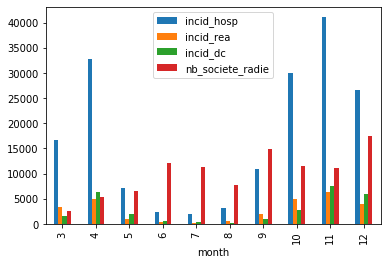

In [25]:
df_datavis = df_groupby_par_mois_societe_covid.toPandas()
df_datavis.plot(kind='bar', x='month', y=["incid_hosp", "incid_rea", "incid_dc", "nb_societe_radie"])
plt.show()

## Conclusion

Pour conclure, nous pouvons constaté avec ce graphique  que le covid a eu un impacte sur les dsociete enf rance en 2020.

Nous voyons ici que l'impacte est effectif 2 mois apres les piques

Par exemple en mars/ avril il y a une augmentation d'hospitalisation ce qui est répercuter 2 mois apres avec l'augmentation du nombre de societe radié.

**OUI** le covid a eu un impacte sur les societe en france